### Title: Forecasting Spare parts inventory
### Client: NewX Services
### Project Ref: PM-PR-0027

#### Business Case: The case business case is on the inventory management. Keeping Inventory of spare in various service centre to the market demand is always a challenge as most service centres spends significant amount in spare parts inventory costs. In spite of this, availability of spare parts is been one of the problem areas.

#### PROJECT GOAL: Create Predictive model for inventory forecasting so that service centre achieve JIT standards.¶

### Approach: ARIMA Model

In [1]:
# !pip install sqlalchemy
# !pip install pymysql

In [2]:
from sqlalchemy import create_engine
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize']=20,12
from pandas import DataFrame
from datetime import timedelta
import calendar

In [3]:
db_host = '18.136.157.135'
username = 'dm_usdata_sql'
user_pass = '37z<49REb&mKnl4AV!vJ'
db_name = 'project_service_data'

conn = create_engine('mysql+pymysql://'+username+':'+user_pass+'@'+db_host+'/'+db_name)
conn.table_names()

['service_data']

In [4]:
query = "SELECT * FROM service_data"                                         
service = pd.read_sql(query,conn)
service.head(5)

,invoice_date,job_card_date,business_partner_name,vehicle_no,vehicle_model,current_km_reading,invoice_line_text
0,30-05-17,30-05-17,shivXXXXXXXXXX,KA03MFXXXX,BAJAJ AVENGER STREET 220,50000,ENGINE OIL
1,02-06-17,31-05-17,KIRAXXXXXXXXXX,KA53ESXXXX,BAJAJ PULSAR NS 200,758,ENGINE OIL
2,02-06-17,31-05-17,KIRAXXXXXXXXXX,KA53ESXXXX,BAJAJ PULSAR NS 200,758,POLISH
3,02-06-17,31-05-17,KIRAXXXXXXXXXX,KA53ESXXXX,BAJAJ PULSAR NS 200,758,CONSUMABLES
4,02-06-17,31-05-17,KIRAXXXXXXXXXX,KA53ESXXXX,BAJAJ PULSAR NS 200,758,COOLANT OIL


In [5]:
# Manual check
# service.to_csv('Project_data/bike_service_data.csv', index=True)

# Extracting Service date and Service spares for grouping

In [6]:
# Object to datetime data type conversion
# Grouping by date and again grouping by month to have equal interval of time series data
# Sort and set date as index...

dataframe=service.loc[:,['job_card_date', 'invoice_line_text']]
dataframe.rename(columns={"job_card_date": "date", "invoice_line_text": "spares"}, inplace=True)
dataframe["date"] = pd.to_datetime(dataframe["date"].astype(str),format='%d/%m/%Y',dayfirst=True,infer_datetime_format=True)
dt_grp_df = dataframe.groupby(['date'], sort=False).count().reset_index()
mm_grp_df = dt_grp_df.groupby(dt_grp_df['date'].dt.strftime('%m/%Y'))['spares'].sum().sort_values()
mdf = pd.DataFrame(mm_grp_df)
mdf.head()

,spares
date,
05/2017,41
01/2019,351
01/2018,968
08/2017,971
10/2017,1054


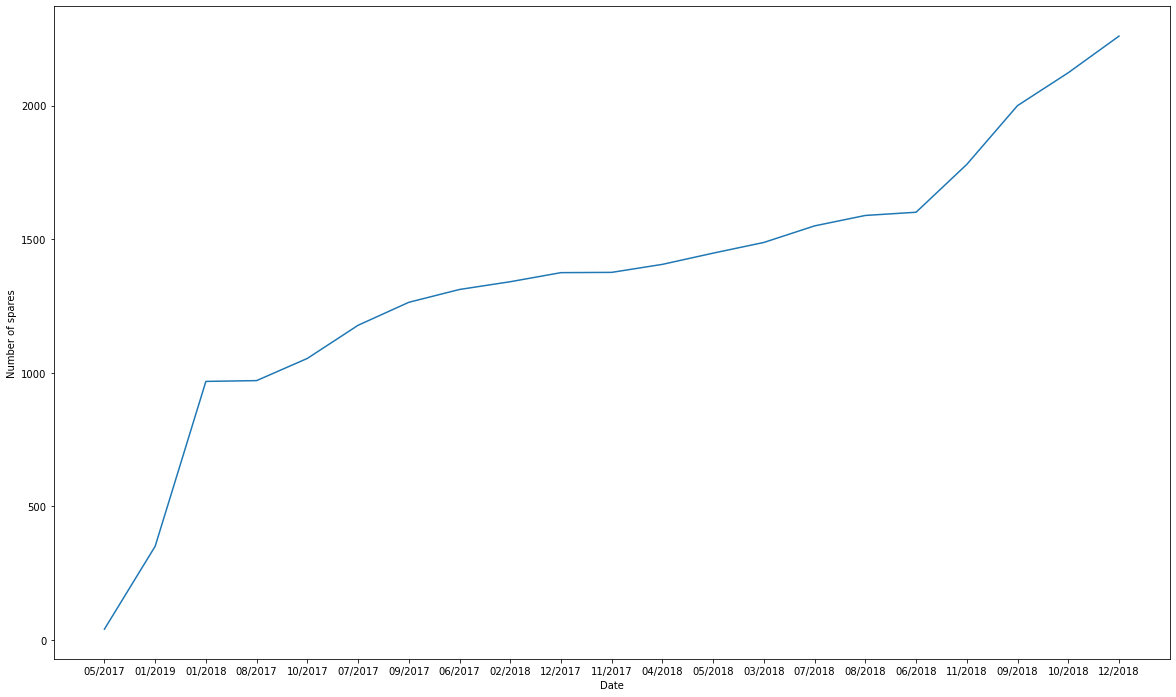

In [7]:
# actual data plot

plt.xlabel("Date")
plt.ylabel("Number of spares")
plt.plot(mdf)

In [8]:
# Object to datetime data type conversion
# Grouping by date and again grouping by date to have equal interval of time series data
# Sort and set date as index...

dataframe=service.loc[:,['job_card_date', 'invoice_line_text']]
dataframe.rename(columns={"job_card_date": "date", "invoice_line_text": "spares"}, inplace=True)
dataframe["date"] = pd.to_datetime(dataframe["date"].astype(str),format='%d/%m/%Y',dayfirst=True,infer_datetime_format=True)
dt_grp_df = dataframe.groupby(['date'], sort=False).count()
df = pd.DataFrame(dt_grp_df)
df.head()

,spares
date,
2017-05-30,1
2017-05-31,40
2017-06-01,49
2017-06-02,16
2017-06-03,40


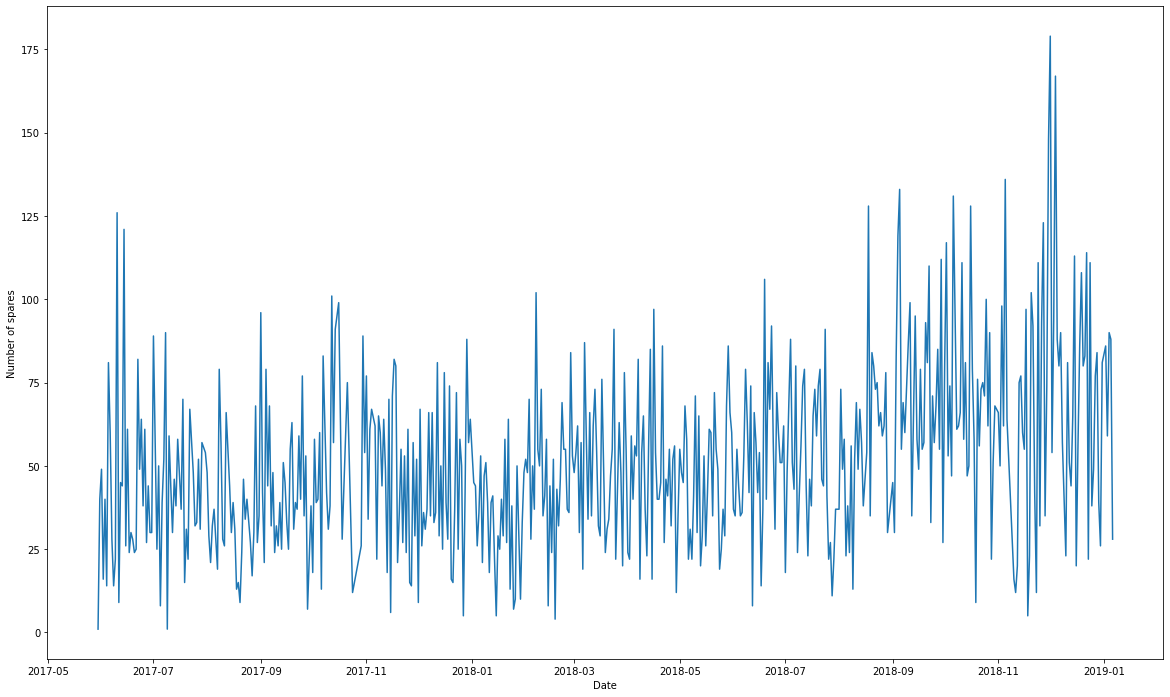

In [9]:
# actual data plot

plt.xlabel("Date")
plt.ylabel("Number of spares")
plt.plot(df)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 553 entries, 2017-05-30 to 2019-01-06
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   spares  553 non-null    int64
dtypes: int64(1)
memory usage: 8.6 KB


In [11]:
# Determining rolling statistics
# visual based check for stationarity

rolmean = df.rolling(window=12).mean()
rolstd = df.rolling(window=12).std()
print(rolmean,rolstd)

# our analysis is by month so we applied the window 12

               spares
date                 
2017-05-30        NaN
2017-05-31        NaN
2017-06-01        NaN
2017-06-02        NaN
2017-06-03        NaN
...               ...
2019-01-02  67.500000
2019-01-03  65.500000
2019-01-04  63.500000
2019-01-05  69.000000
2019-01-06  62.083333

[553 rows x 1 columns]                spares
date                 
2017-05-30        NaN
2017-05-31        NaN
2017-06-01        NaN
2017-06-02        NaN
2017-06-03        NaN
...               ...
2019-01-02  31.621339
2019-01-03  31.309307
2019-01-04  28.576850
2019-01-05  26.108167
2019-01-06  24.937953

[553 rows x 1 columns]


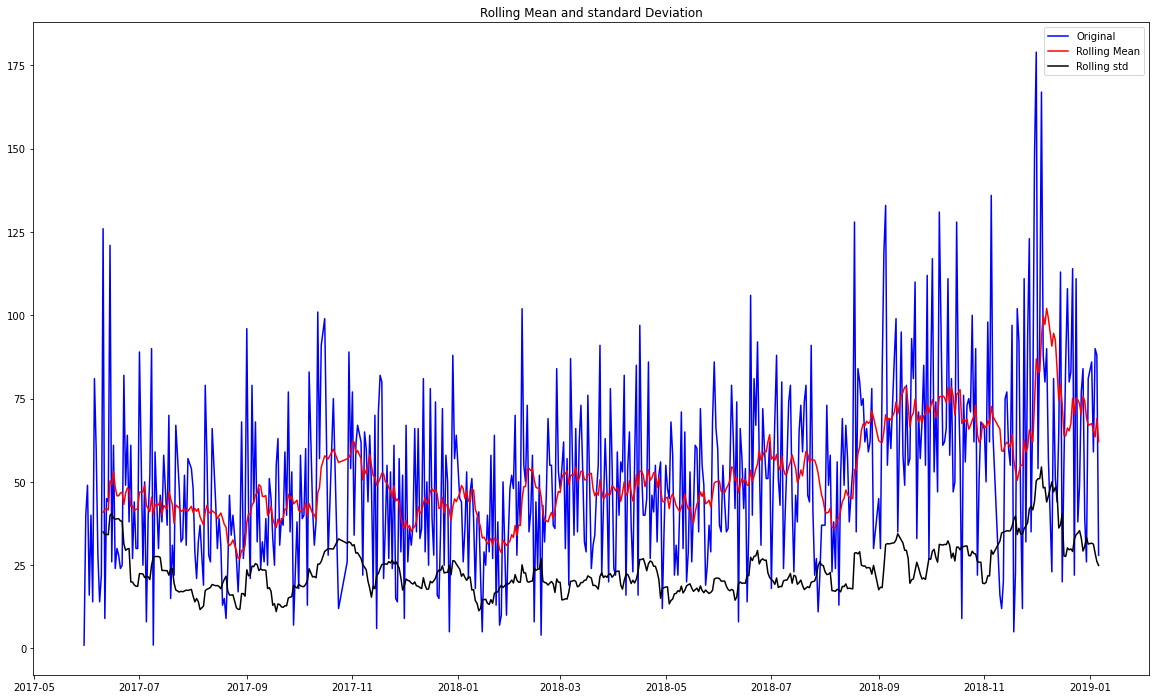

In [12]:
# plot rolling statistics
orig = plt.plot(df, color='blue', label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
stnd = plt.plot(rolstd, color='black', label='Rolling std')
plt.legend(loc='best')
plt.title('Rolling Mean and standard Deviation')
plt.show(block=False)

# Conclusion: the mean and standard deviations are not constant

In [13]:
# Augmented Dickey-FUller Test - ADF Test

from statsmodels.tsa.stattools import adfuller

print('Results of Dickey-Fuller Test')
dftest = adfuller(df['spares'], autolag='AIC') 
# Acaicae information criteria; this analysise difference b/w actual and test

dfoutput = pd.Series(dftest[0:4], index=['Test statistics','p-value','# lags used','# of observations used'])
for key, value in dftest[4].items():
    dfoutput['Critical value (%s)'%key]=value

print(dfoutput)


Results of Dickey-Fuller Test
Test statistics            -2.893185
p-value                     0.046146
# lags used                13.000000
# of observations used    539.000000
Critical value (1%)        -3.442541
Critical value (5%)        -2.866917
Critical value (10%)       -2.569634
dtype: float64


In [14]:
# P-value should be < 0.05
# 4.563102e-09 hence we reject the null hypothisisi

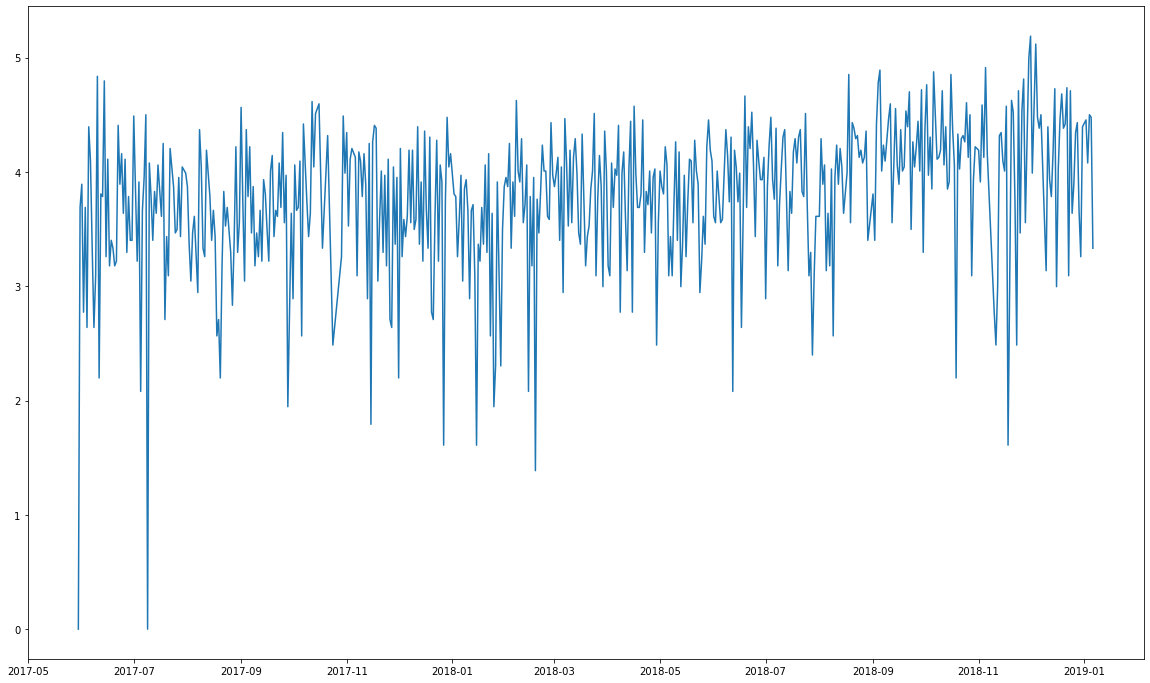

In [15]:
# estimating trend based on the log

indexed_df_logScale = np.log(df)
plt.plot(indexed_df_logScale)

In [16]:
# you can see the y axis has changed; becoz the scale has been changed 
# but the trend remains same 

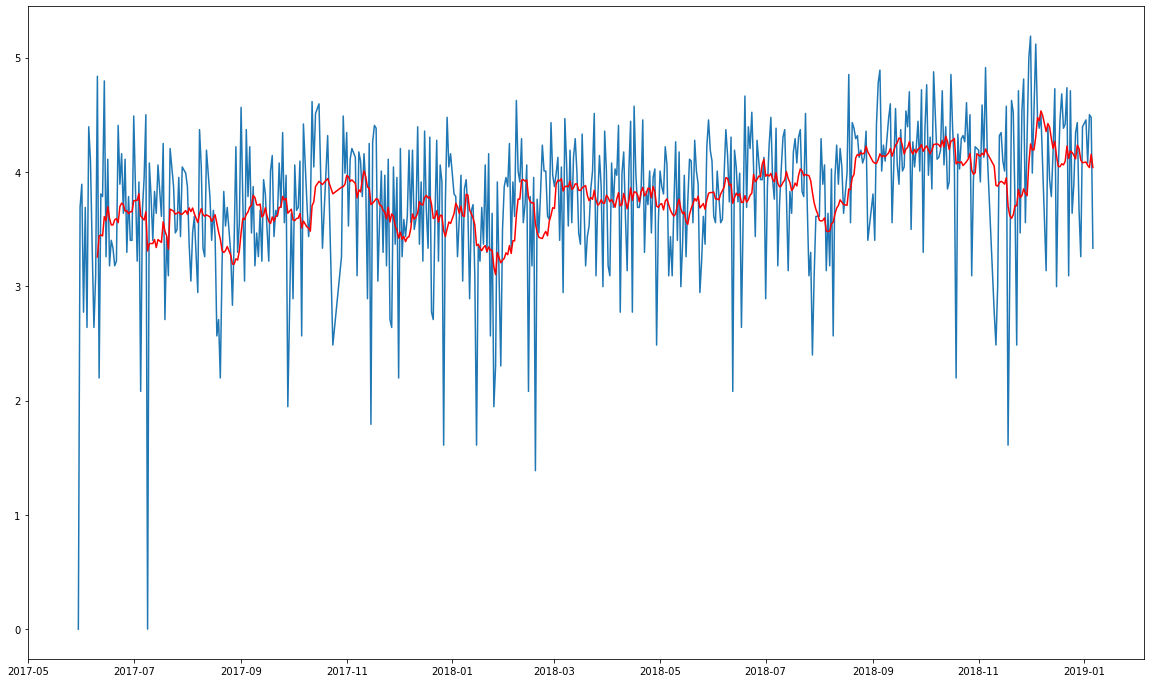

In [17]:
# moving avg calculation with same window based on log time series
# our datA IS ALREADY IN LOG FORM for 12 months window

movingAvg = indexed_df_logScale.rolling(window=12).mean()
movingSTD = indexed_df_logScale.rolling(window=12).std()
plt.plot(indexed_df_logScale)
plt.plot(movingAvg, color='Red')

In [18]:
# again its not stationary; its moving with the time; upward trend; not stationaty

In [19]:
# get the differnce b/w moving average and actual number of passengers
# this is one of the transformation to make our data stationary

datasetLogScaleMovingAvg = indexed_df_logScale - movingAvg
datasetLogScaleMovingAvg.head(12)

,spares
date,
2017-05-30,NaN
2017-05-31,NaN
2017-06-01,NaN
2017-06-02,NaN
2017-06-03,NaN
2017-06-04,NaN
2017-06-05,NaN
2017-06-06,NaN
2017-06-07,NaN


In [20]:
# you see lot of NaNs; lets remove them

datasetLogScaleMovingAvg.dropna(inplace=True)
datasetLogScaleMovingAvg.head(10)

,spares
date,
2017-06-10,1.580565
2017-06-11,-1.241595
2017-06-12,0.358028
2017-06-13,0.344524
2017-06-14,1.187525
2017-06-15,-0.314270
2017-06-16,0.415856
2017-06-17,-0.415598
2017-06-18,-0.134692


In [21]:
# augmented Dickey-fuller test function

from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #determining rolling statistics
    movingAvg = timeseries.rolling(window=12).mean()
    movingSTD = timeseries.rolling(window=12).std() 
    
    # lets see in the plots of rolling statistics
    original = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(movingAvg, color='red', label='Rolling Mean')
    std = plt.plot(movingSTD, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('rolling means & statndard deviation')
    plt.show(block=False)
    
    # perform Dickey-fuller test
    print('Results of Dickey-fuller test')
    dftest = adfuller(timeseries['spares'], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['test statistic','p-value','#of lags used','number of observations used'])
    for key,value in dftest[4].items():
        dfoutput['critical value (%s)'%key]=value
    print (dfoutput)
    

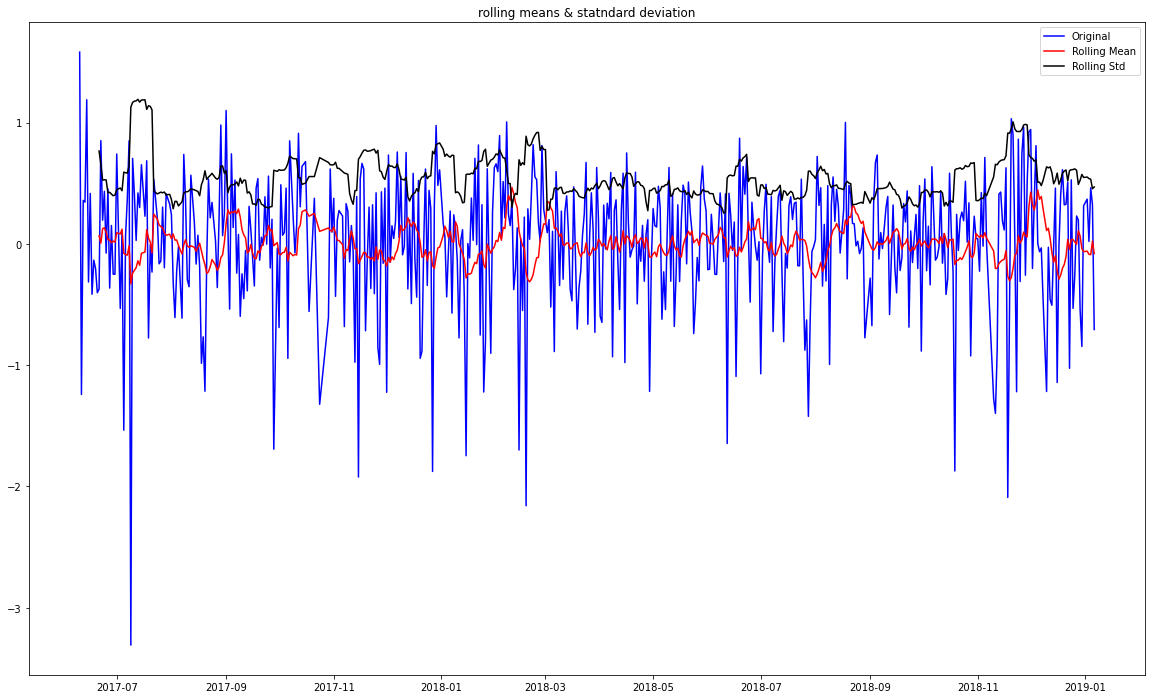

Results of Dickey-fuller test
test statistic                -8.571765e+00
p-value                        8.161510e-14
#of lags used                  1.500000e+01
number of observations used    5.260000e+02
critical value (1%)           -3.442843e+00
critical value (5%)           -2.867050e+00
critical value (10%)          -2.569705e+00
dtype: float64


In [22]:
# run the above function
test_stationarity(datasetLogScaleMovingAvg)

In [23]:
# still there is no trend but better than previous

# p-value is relatively less than 0.05

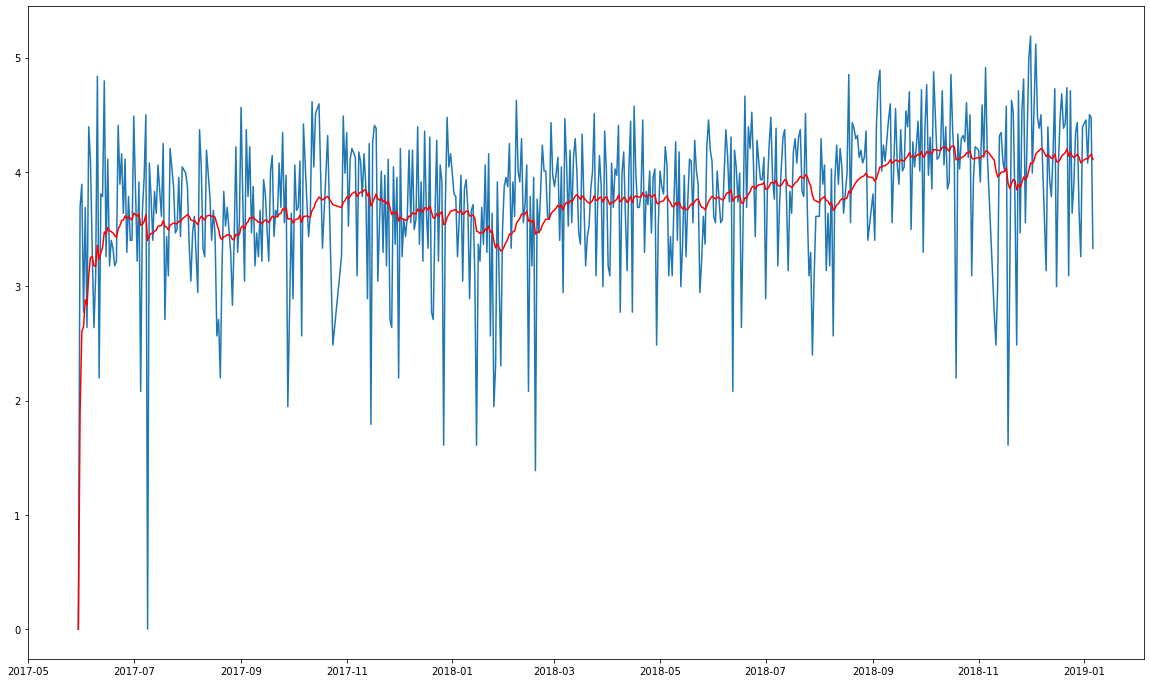

In [24]:
# weighted average calcuation of time series with simple mean

exponentialDecayWeightedAvg = indexed_df_logScale.ewm(halflife=12,min_periods=0, adjust=True).mean()
plt.plot(indexed_df_logScale)
plt.plot(exponentialDecayWeightedAvg, color='red')

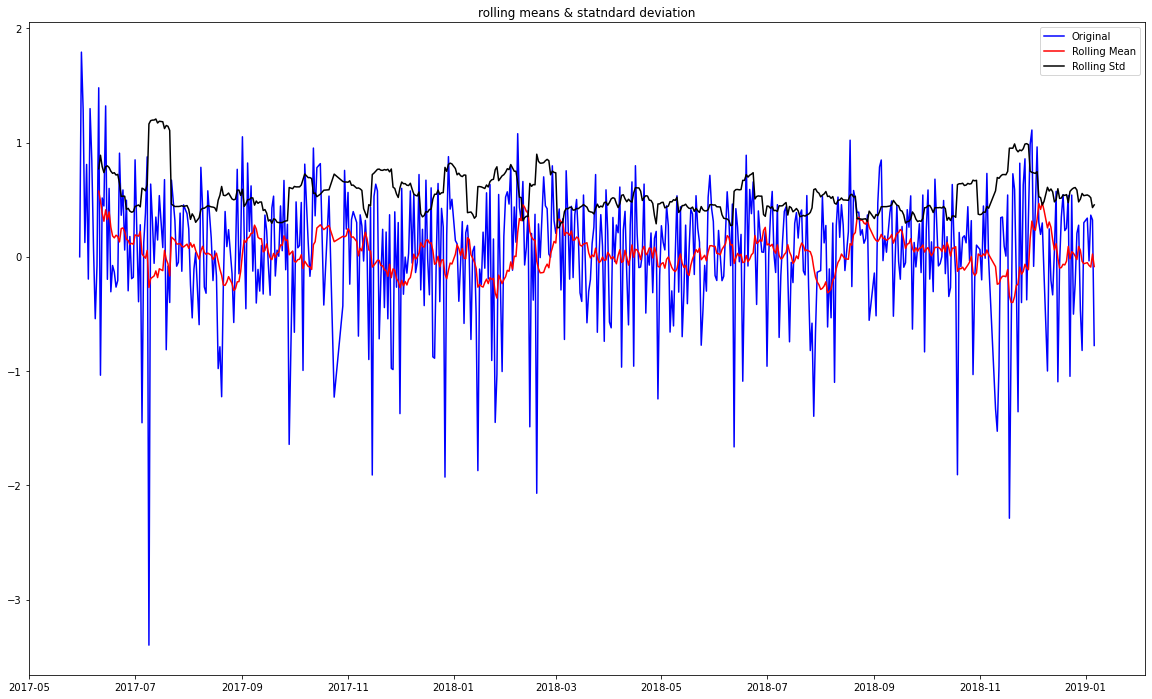

Results of Dickey-fuller test
test statistic                 -24.630092
p-value                          0.000000
#of lags used                    0.000000
number of observations used    552.000000
critical value (1%)             -3.442252
critical value (5%)             -2.866790
critical value (10%)            -2.569566
dtype: float64


In [25]:
# as the time series in upward trend the weighted average as well with respect to the time

datasetLogScaleMinusMovingExponentialDecayAverage = indexed_df_logScale - exponentialDecayWeightedAvg
test_stationarity(datasetLogScaleMinusMovingExponentialDecayAverage)

### standard deviation is quite flat no trend; rolling average is much better than previous; 
### results of abcf also good, p-value better than before
### test statistics shows the data now stationary; this transformation reveals the stationary

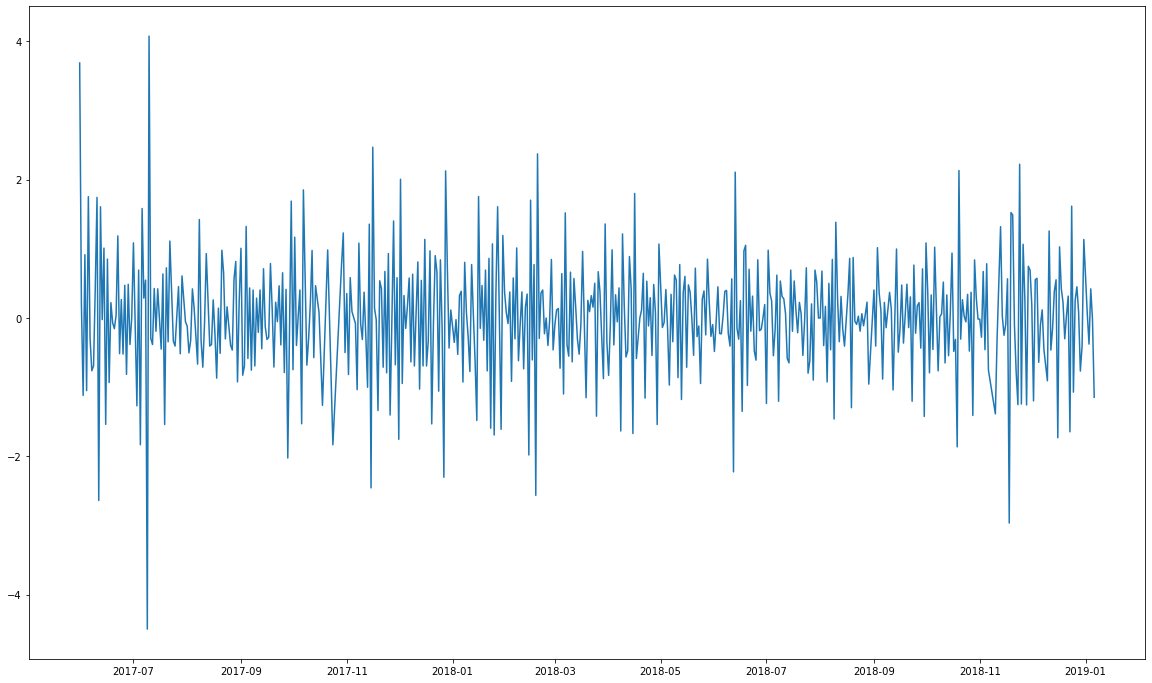

In [26]:
# lets shift the value into time series so that we can use for forecasting
# earlier subtracted value of mean from actual value
# now lets use the python function shift() do the same

datasetLogDiffShifting = indexed_df_logScale - indexed_df_logScale.shift()
plt.plot(datasetLogDiffShifting)


### here the lag 1
### ARIMA has three model in it AR, MA & D
### ARIMA takes three input parameters;   the D value will be 1 now; D stands for difference 

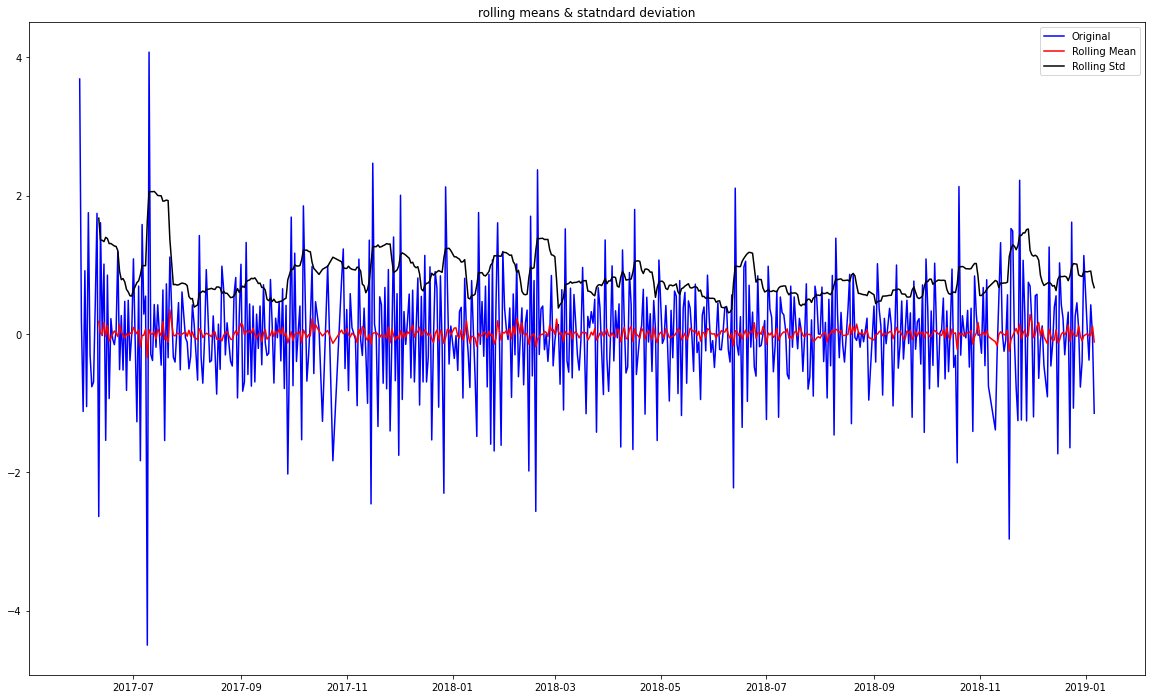

Results of Dickey-fuller test
test statistic                -9.356614e+00
p-value                        8.027649e-16
#of lags used                  1.900000e+01
number of observations used    5.320000e+02
critical value (1%)           -3.442702e+00
critical value (5%)           -2.866988e+00
critical value (10%)          -2.569672e+00
dtype: float64


In [27]:
# drop the NaN value
datasetLogDiffShifting.dropna(inplace=True)
test_stationarity(datasetLogDiffShifting)


### here the output os quite flat
### null hypothesis or ADFT is rejected hence the time series is stationarity now

<ipython-input-28-c7cd0e04f727>:4: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  decomposition = seasonal_decompose(indexed_df_logScale, model = 'additive', freq=12)


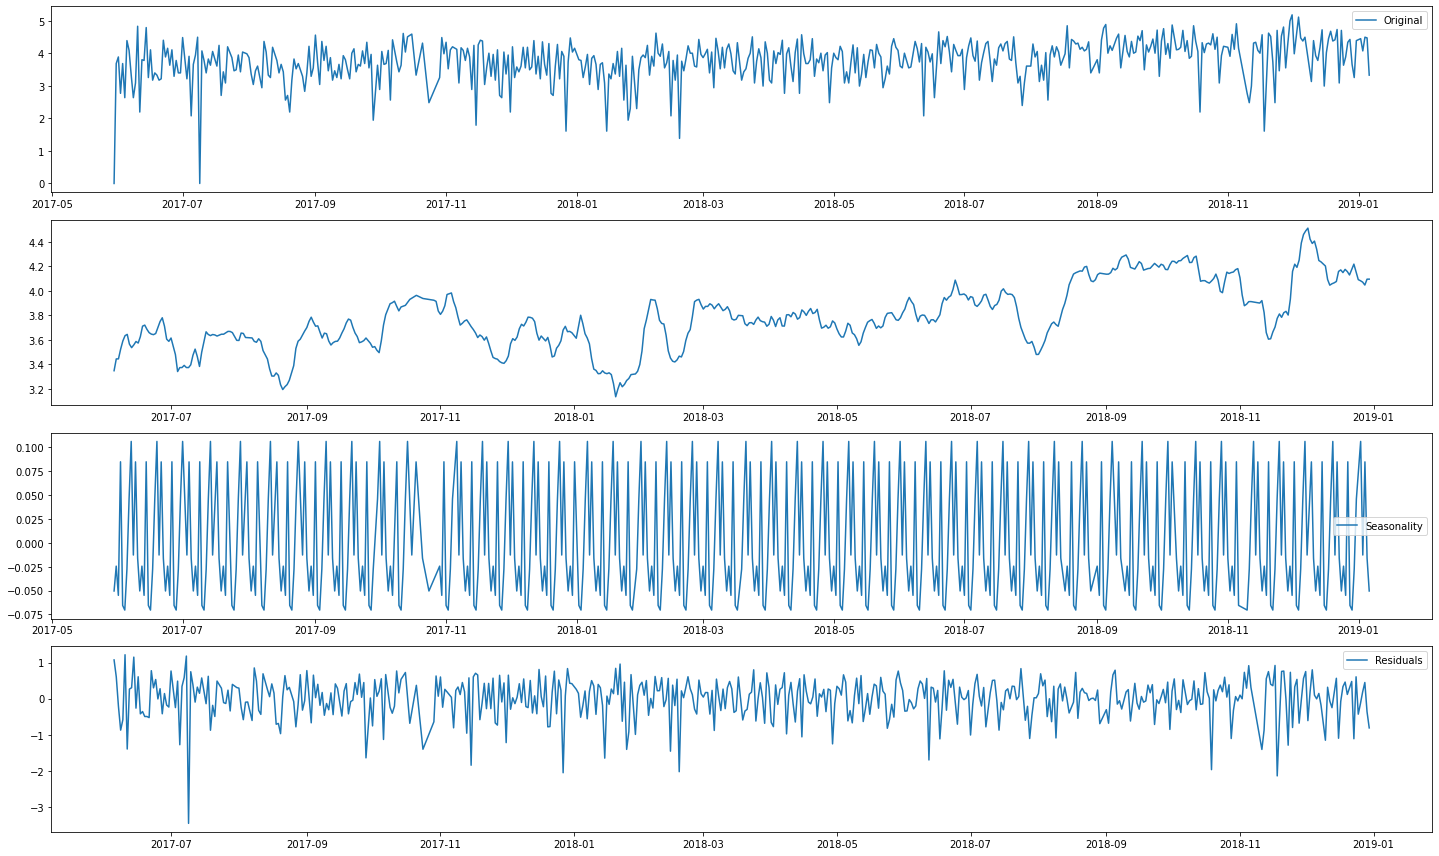

In [28]:
# let see the visual components of time seriese

from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(indexed_df_logScale, model = 'additive', freq=12)

# references
# https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/
# https://stackoverflow.com/questions/52979131/none-freq-not-allowing-seasonal-decompose


trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
residual = residual.to_frame()
residual.columns=['spares']


plt.subplot(411)
plt.plot(indexed_df_logScale, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.subplot(413)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()


### see the three components trend, seasonal, residual
### overall original data has trend
### only the trend line in the second which is upwards
### sesionality also present with high scale
### last residuals: its nothing but irregularity in your data; yes its random; no shape

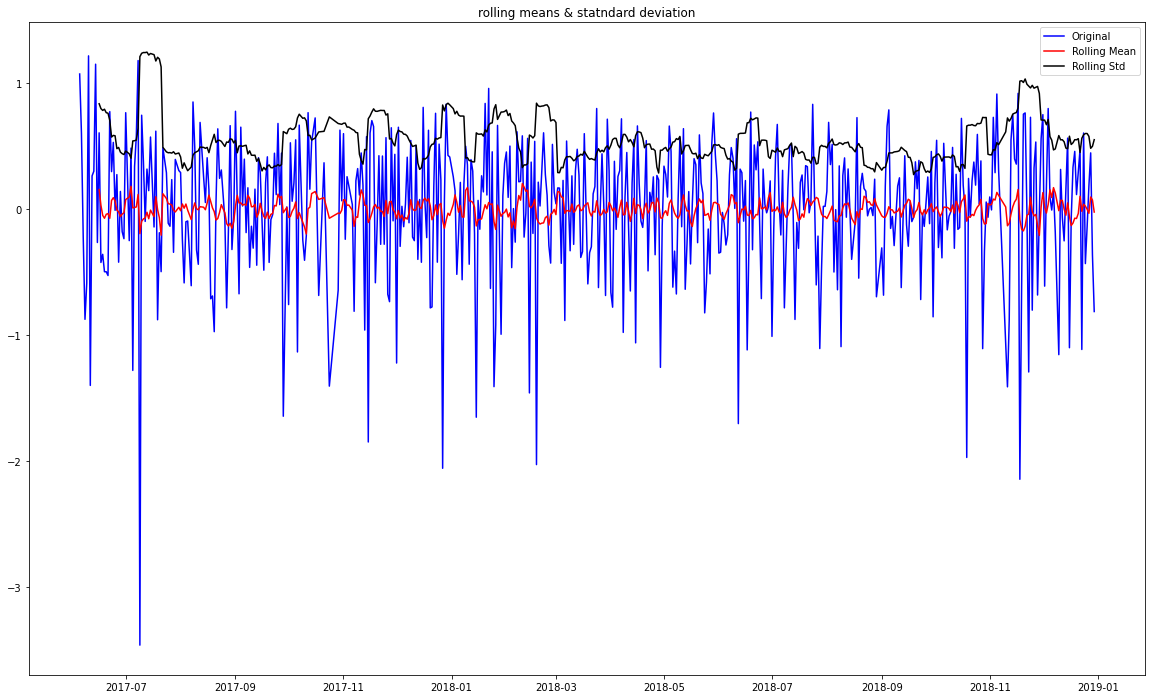

Results of Dickey-fuller test
test statistic                -1.023381e+01
p-value                        4.949205e-18
#of lags used                  1.900000e+01
number of observations used    5.210000e+02
critical value (1%)           -3.442964e+00
critical value (5%)           -2.867103e+00
critical value (10%)          -2.569733e+00
dtype: float64


In [29]:
# we are checking the noise whether its stationary or not
# processing residual data
decomposedLogData = residual
decomposedLogData.dropna(inplace=True)
test_stationarity(decomposedLogData)

### viasually its not stationary
### that's why we need moving average paramenter base
### that will help what will happen next

### Now we know the value of D. In order to find the value of P and Q
###     i.e., value of auto regressive lags & value of moving average
###     lets plot #ACF and PACF graph 

In [30]:
#ACF and PACF graph

from statsmodels.tsa.stattools import acf, pacf

C:\Users\Thiri\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:662: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


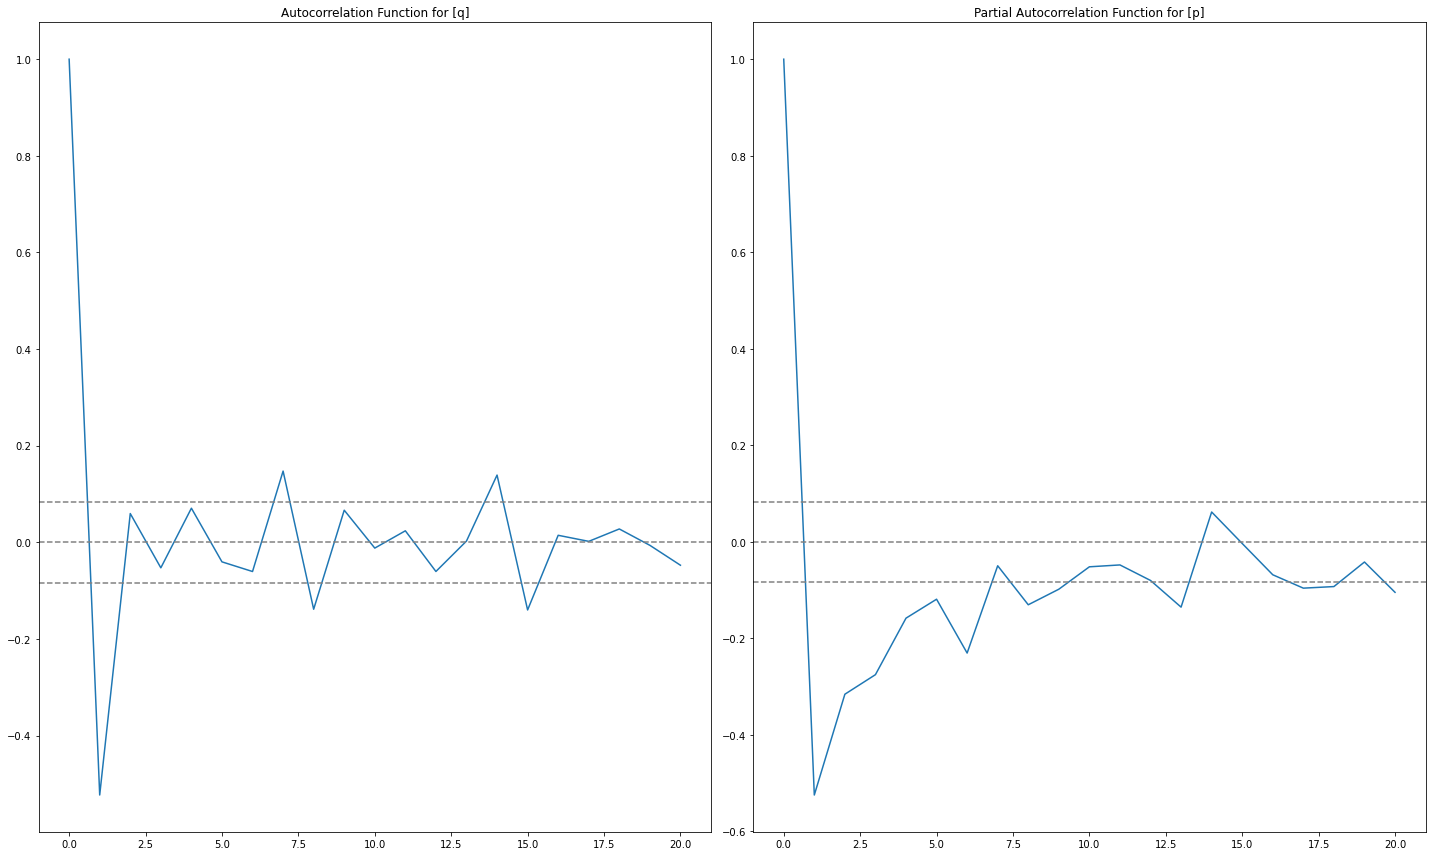

In [31]:
log_acf = acf(datasetLogDiffShifting, nlags=20)
log_pacf = pacf(datasetLogDiffShifting, nlags=20, method='ols') 
# OLS means: Ordinary least Square method


#plot ACF (to clculate q)
plt.subplot(121)
plt.plot(log_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--', color='gray')
plt.title('Autocorrelation Function for [q]')

#PACF plot (to calulate p)
plt.subplot(122)
plt.plot(log_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function for [p]')

plt.tight_layout()


In [32]:
# lets determine P & Q
#  - find the first instance of the graph meeting 0
#  - the other margins are our confident value
#  - q = 1 & p = 1
#  - later substitute p, d & d to ARIMA

# ARIMA Model

In [33]:
from statsmodels.tsa.arima_model import ARIMA

C:\Users\Thiri\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\Thiri\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency

Plotting AR model


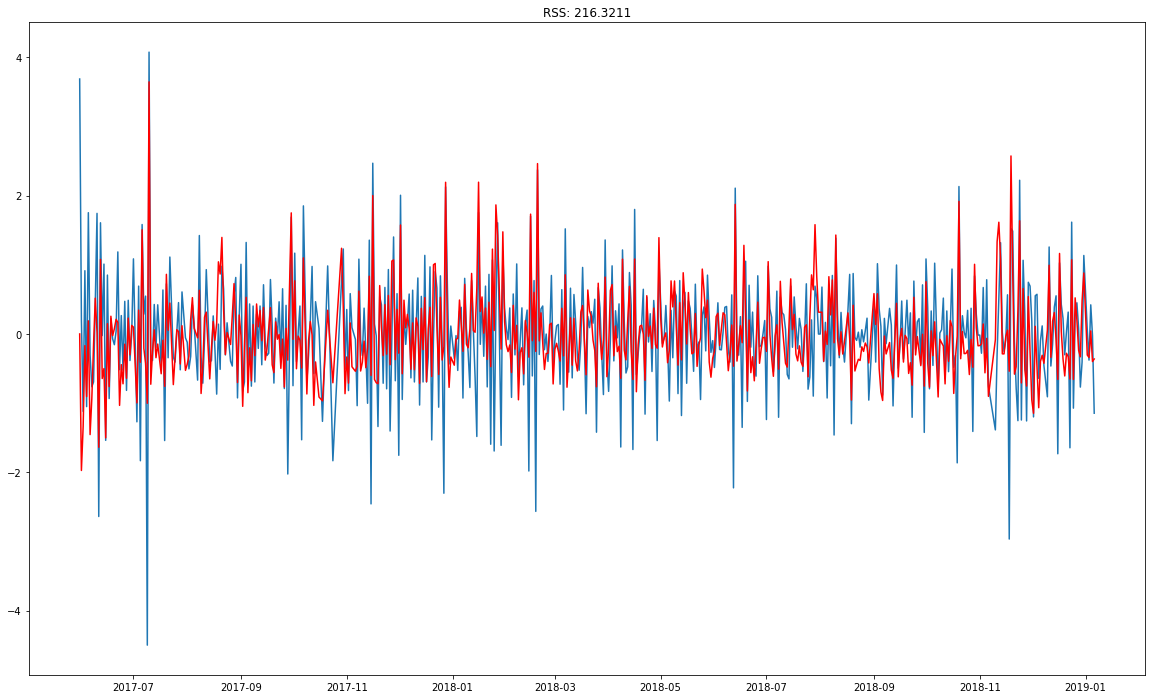

In [34]:
# lets take the moving average into the consideration for prediction

# p=1; d=1; q=1
model = ARIMA(indexed_df_logScale, order=(1,1,2))
result_ARIMA = model.fit(disp=-1)
plt.plot(datasetLogDiffShifting)
plt.plot(result_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((result_ARIMA.fittedvalues-datasetLogDiffShifting['spares'])**2))

print('Plotting AR model')

# RSS is quite bad

# RSS: Residual Sum Of Squares (the greater RSS is the worst it is)

C:\Users\Thiri\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\Thiri\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\Thiri\anaconda3\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
C:\Users\Thiri\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmode

Plotting AR model


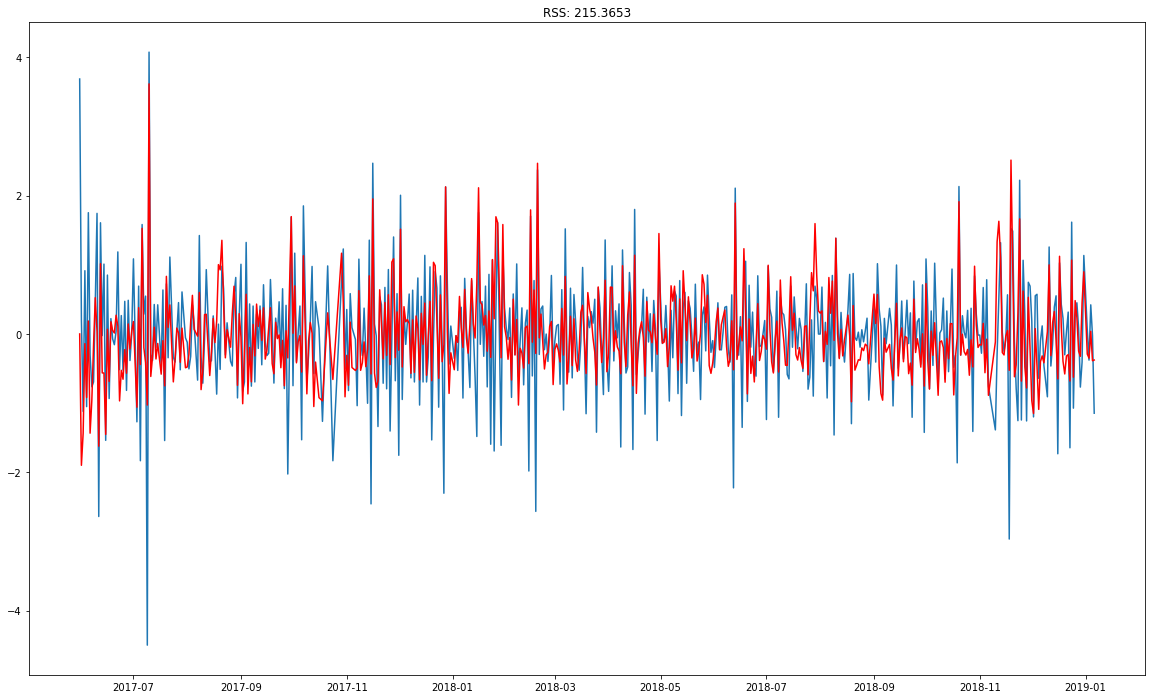

In [35]:
# lets try other combinations 
# p=2; d=1; q=2

model = ARIMA(indexed_df_logScale, order=(2,1,2))
result_ARIMA = model.fit(disp=-1)
plt.plot(datasetLogDiffShifting)
plt.plot(result_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((result_ARIMA.fittedvalues-datasetLogDiffShifting['spares'])**2))

print('Plotting AR model')

# RSS not coming down

C:\Users\Thiri\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\Thiri\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


Plotting AR model


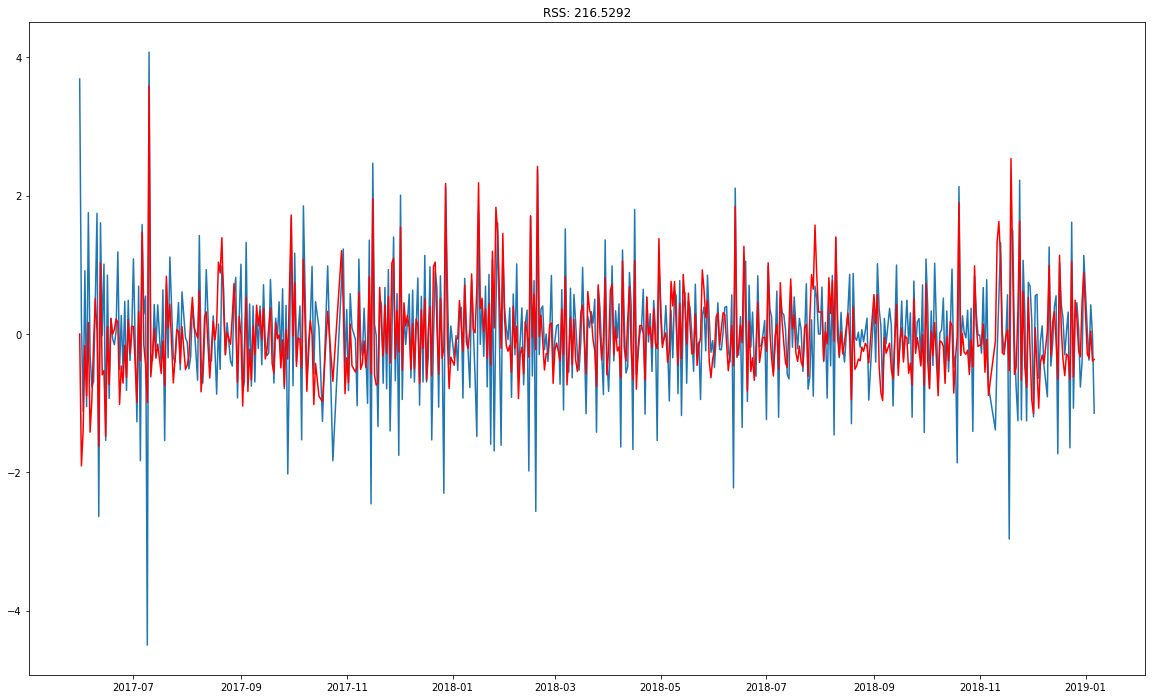

In [36]:
# lets try other combinations 
# p=2; d=1; q=2

model = ARIMA(indexed_df_logScale, order=(0,1,2))
result_ARIMA = model.fit(disp=-1)
plt.plot(datasetLogDiffShifting)
plt.plot(result_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((result_ARIMA.fittedvalues-datasetLogDiffShifting['spares'])**2))

print('Plotting AR model')

# RSS never getting better

In [37]:
# converted values into series

predictions_ARIMA_diff = pd.Series(result_ARIMA.fittedvalues, copy=True)
print(predictions_ARIMA_diff.head())

date
2017-05-31    0.001247
2017-06-01   -1.906805
2017-06-02   -1.399273
2017-06-03   -0.167381
2017-06-04   -0.894015
dtype: float64


In [38]:
# Convert to cummulative

predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print(predictions_ARIMA_diff_cumsum.head())

date
2017-05-31    0.001247
2017-06-01   -1.905558
2017-06-02   -3.304832
2017-06-03   -3.472213
2017-06-04   -4.366228
dtype: float64


In [39]:
predictions_ARIMA_log = pd.Series(indexed_df_logScale['spares'].iloc[0], index=indexed_df_logScale.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA_log.head()

date
2017-05-30    0.000000
2017-05-31    0.001247
2017-06-01   -1.905558
2017-06-02   -3.304832
2017-06-03   -3.472213
dtype: float64

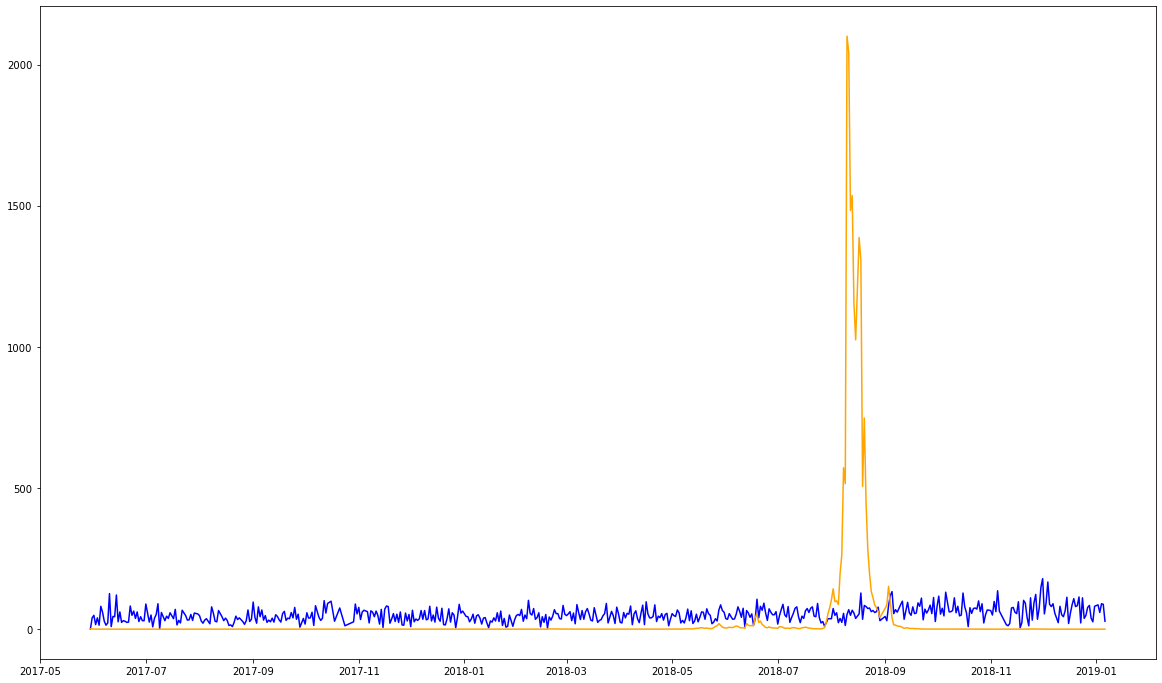

In [40]:
#after performing all those transformation, we need exponential of all data so it comes back to original
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(df, color='blue', label='Original')
plt.plot(predictions_ARIMA, color='orange', label='predictions')

## Bad prediction

In [41]:
indexed_df_logScale

,spares
date,
2017-05-30,0.000000
2017-05-31,3.688879
2017-06-01,3.891820
2017-06-02,2.772589
2017-06-03,3.688879
...,...
2019-01-02,4.454347
2019-01-03,4.077537
2019-01-04,4.499810


C:\Users\Thiri\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\Users\Thiri\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\Users\Thiri\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


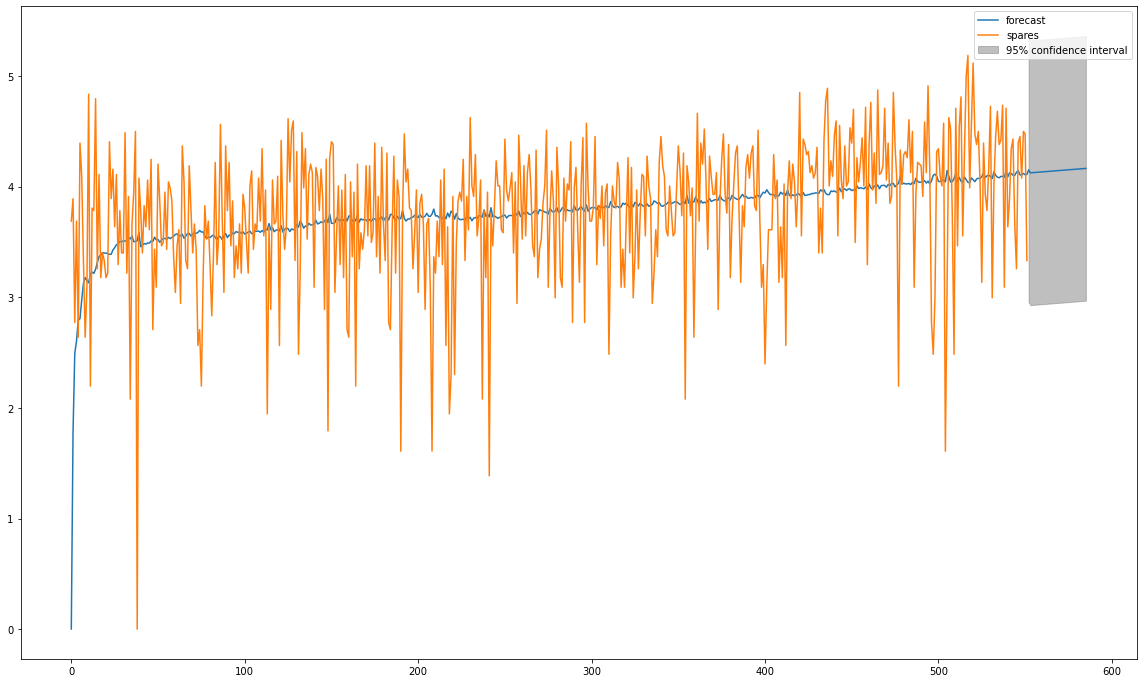

In [42]:
# Prediction for next 3 months; (3 x 12 = 36) + 553 = 586
result_ARIMA.plot_predict(1,586)
x=result_ARIMA.forecast(steps=36)